# Heritability Estimation: AD vs Factor Models

Heritability estimation is a fundamental concept in genetics, used to quantify the proportion of phenotypic variance explained by genetic factors. This notebook explores heritability estimation under two different genotype encoding schemes:

1. **AD Model (Additive-Dominance Model)**: This classical model represents genetic effects as the sum of additive (0, 1, 2) and dominance (0, 1, 0) components.
2. **Factor Model**: This alternative encoding decomposes genetic effects into heterozygous (0, 1, 0) and homozygous (0, 1, 0) indicator components.

## Research Question

Do genotype encoding schemes affect heritability estimates? To address this question, we designed simulations that directly compare heritability estimates under the AD and Factor models while keeping the underlying genetic architecture identical. Specifically, we assume a **purely additive genetic architecture** to isolate the influence of encoding schemes from the genetic architecture itself.

## Simulation Design

1. **Phenotype Generation**:
   - Phenotypes are simulated under two encoding schemes: the AD model and the Factor model.
   - Both models use the same set of base additive effects ($\beta$), ensuring that the underlying genetic architecture is identical.
   - In the AD model, dominance effects are excluded, reducing the model to a simple additive structure.
   - In the Factor model, additive effects are decomposed into heterozygous and homozygous components, with homozygous effects set to twice the heterozygous effects to preserve the linear additive assumption.

2. **Environmental Effects**:
   - Phenotypes are generated using the linear model: $y = X\beta + \varepsilon$
   - Environmental effects ($\varepsilon$) are partitioned into:
     - **Family-shared effects ($c$)**: Identical within twin pairs to mimic shared environments.
     - **Individual-specific effects ($e$)**: Unique to each individual.

3. **Dataset Composition**:
   - Each dataset includes: unrelated individuals, DZ, and MZ twin pairs.
     
## Heritability Estimation

For each dataset, we estimate heritability using three methods:
1. **Twin-based heritability ($h^2_{\text{twin}}$)**: Broad-sense heritability ($H^2$) estimated from twin correlations. Note that under a _purely additive genetic architecture_, twin-based broad-sense heritability is equivalent to **narrow-sense heritability ($h^2$)** in the AD model.
2. **SNP-based heritability using the AD model ($h^2_{\text{add}}$ and $h^2_{\text{dom}}$)**: Estimated using additive genetic relatedness matrices (GRMs). The total SNP heritability under AD model is defined as $h^2_{\text{AD}} = h^2_{\text{add}} + h^2_{\text{dom}}$
3. **SNP-based heritability using the Factor model ($h^2_{\text{het}}$ and $h^2_{\text{hom}}$)**: Estimated using Factor-based GRMs. The total SNP heritability under Facvtor model is defined as $h^2_{\text{F}} = h^2_{\text{het}} + h^2_{\text{hom}}$


---
# 0. Setup
---

In [3]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipynbname
from scipy import linalg, stats

# Define paths and add custom modules
notebook_path = ipynbname.path()
notebook_dir = os.path.dirname(notebook_path)
ROOT_PATH = os.path.abspath(os.path.join(notebook_dir, '../..'))
sys.path.insert(0, os.path.join(ROOT_PATH, "src", "famgen"))

In [4]:
# Genotype simulation for twin studies
def generate_twin_genotypes(
    n_fam,  # Number of families
    n_snp,  # Number of SNPs
    maf_lim=[0.05, 0.5]  # Minor Allele Frequency (MAF) range
):
    """
    Generate genotype data for monozygotic (MZ) and dizygotic (DZ) twins.
    
    Parameters:
        n_fam (int): Number of families to simulate.
        n_snp (int): Number of SNPs to simulate.
        maf_lim (list): Range of minor allele frequencies [min, max].
    
    Returns:
        tuple: DataFrames for MZ twins, DZ twins, and the MAFs.
    """
    from famgam.core.genotype import FamGenoSimul

    def create_mz_df(geno_df, n_fam):
        """
        Create a DataFrame for monozygotic (MZ) twins.
        
        Parameters:
            geno_df (DataFrame): Genotype data for all individuals.
            n_fam (int): Number of families.
        
        Returns:
            DataFrame: Genotype data for MZ twins.
        """
        return (
            geno_df[geno_df["family_id"] < (n_fam / 2)]  # Select first half of families
            .query("role == 'offspring'")  # Filter offspring only
            .drop_duplicates(subset=["family_id"], keep="first")  # Keep one offspring per family
            .pipe(lambda df: pd.concat([df, df]))  # Duplicate rows to simulate MZ twins
            .sort_values("family_id")  # Sort by family ID
            .reset_index(drop=True)  # Reset index
            .assign(twin_type="MZ")  # Add twin type column
        )

    def create_dz_df(geno_df, n_fam):
        """
        Create a DataFrame for dizygotic (DZ) twins.
        
        Parameters:
            geno_df (DataFrame): Genotype data for all individuals.
            n_fam (int): Number of families.
        
        Returns:
            DataFrame: Genotype data for DZ twins.
        """
        return (
            geno_df[geno_df["family_id"] >= (n_fam / 2)]  # Select second half of families
            .query("role == 'offspring'")  # Filter offspring only
            .sort_values("family_id")  # Sort by family ID
            .reset_index(drop=True)  # Reset index
            .assign(twin_type="DZ")  # Add twin type column
        )

    # Initialize the genotype simulator
    fam_geno = FamGenoSimul(n_snp, maf_lim=maf_lim)
    
    # Generate minor allele frequencies (MAFs)
    mafs = fam_geno.get_maf()
    
    # Generate parent haplotypes for the specified number of families
    fam_geno.generate_parent_haplotype(n_fam)
    
    # Generate offspring haplotypes (2 offspring per family)
    fam_geno.make_offspring_haplotype(num_offspring=2)
    
    # Retrieve genotype data as a DataFrame
    geno_df = fam_geno.get_genotype(as_dataframe=True)
    
    # Create DataFrames for MZ and DZ twins
    df_mz = create_mz_df(geno_df, n_fam)
    df_dz = create_dz_df(geno_df, n_fam)
    
    # Return the MZ and DZ twin data along with the MAFs
    return df_mz, df_dz, mafs


In [5]:
# Utility function to extract genotype data from a DataFrame
def get_genotype_from_df(twin_df: pd.DataFrame):
    """
    Extract genotype data from a twin DataFrame by removing non-genotype columns.
    
    Parameters:
        twin_df (pd.DataFrame): DataFrame containing twin genotype data.
    
    Returns:
        np.ndarray: Numpy array of genotype data.
    """
    # Identify columns that do not start with "variant" and remove them
    colns_to_remove = [col for col in twin_df.columns if col.split("_")[0] != "variant"]
    # Drop the identified columns and convert the remaining data to a numpy array
    geno = twin_df.drop(columns=colns_to_remove).to_numpy()
    return geno


Before analyzing the twin data, let's first inspect its structure. 
We will display the first few rows of the monozygotic (MZ) and dizygotic (DZ) twin datasets to understand their composition.

In [25]:
# generate twin genotype data
df_mz, df_dz, mafs = generate_twin_genotypes(
    n_fam = 10_000,
    n_snp = 1_000,
    maf_lim = [0.05, 0.5]
)

# Check the structure of MZ and DZ twin data
print("-----------------------")
print("Monozygotic (MZ) Twins:")
print("-----------------------")
print(df_mz.iloc[:5, :5])

print("\n-----------------------")
print("Dizygotic (DZ) Twins:")
print("-----------------------")
print(df_dz.iloc[:5, :5])

-----------------------
Monozygotic (MZ) Twins:
-----------------------
   family_id       role  variant_1  variant_2  variant_3
0          0  offspring          0          0          0
1          0  offspring          0          0          0
2          1  offspring          0          0          1
3          1  offspring          0          0          1
4          2  offspring          1          1          0

-----------------------
Dizygotic (DZ) Twins:
-----------------------
   family_id       role  variant_1  variant_2  variant_3
0       5000  offspring          0          0          1
1       5000  offspring          0          1          1
2       5001  offspring          1          0          2
3       5001  offspring          0          0          2
4       5002  offspring          1          0          1


To ensure that the twin data has been generated correctly:
1. **MZ Twins**: The genotypes of MZ twins should be identical across all variants.
2. **DZ Twins**: The genotypes of DZ twins should be similar but not identical, as they share approximately 50% of their genetic material.

We will calculate the average correlation of genotypes between twin pairs for both MZ and DZ twins across all variants.

In [26]:
def _compute_average_correlation(df_twin):
    g_twin = get_genotype_from_df(df_twin)
    n_snp = g_twin.shape[1]

    twin1 = g_twin[::2]  # Twin 1 (even rows)
    twin2 = g_twin[1::2]  # Twin 2 (odd rows)

    correlations = [np.corrcoef(twin1[:, i], twin2[:, i])[0, 1] for i in range(n_snp)]
    avg_correlation = np.nanmean(correlations)
    return avg_correlation


print(f"""
Average correlation for MZ twins across all variants: {_compute_average_correlation(df_mz):.4f}
""")

print(f"""
Average correlation for DZ twins across all variants: {_compute_average_correlation(df_dz):.4f}
""")


Average correlation for MZ twins across all variants: 1.0000


Average correlation for DZ twins across all variants: 0.5000



and we'll make unrelated individual set by selecting every first twin from each pair in the MZ and DZ twin dataset. 

We will then calculate the correlation of genotypes between these unrelated individuals to verify that they are indeed unrelated.

In [27]:
def _compute_average_correlation(df_mz, df_dz):
    g_mz = get_genotype_from_df(df_mz)
    g_dz = get_genotype_from_df(df_dz)
    n_snp = g_mz.shape[1]
    
    unrel_from_mz = g_mz[::2]  
    unrel_from_dz = g_dz[::2]  

    correlations = [np.corrcoef(unrel_from_mz[:, i], unrel_from_dz[:, i])[0, 1] for i in range(n_snp)]
    avg_correlation = np.nanmean(correlations)
    return avg_correlation

print(f"""
Average correlation for unrelatives across all variants: {_compute_average_correlation(df_mz, df_dz):.4f}
""")



Average correlation for unrelatives across all variants: -0.0006



In [20]:
# Effect size generation based on genetic models
def create_beta(n_snp, base_model, **kwargs):
    """
    Generate beta coefficients for SNPs based on the specified genetic model.
    
    Parameters:
        n_snp (int): Number of SNPs.
        base_model (str): Genetic model type ("AD" or "Factor").
        **kwargs: Additional parameters specific to the chosen model.
            - For "AD" model:
                var_a (float): Additive genetic variance.
                var_d (float): Dominance genetic variance.
            - For "Factor" model:
                var_het (float): Heterozygous variance.
                var_hom (float): Homozygous variance.
                rho_hh (float): Correlation between heterozygous and homozygous effects.
    
    Returns:
        np.ndarray: Array of beta coefficients for each SNP.
    """
    if base_model == "AD":
        # Extract required parameters for "AD" model
        var_a = kwargs.get("var_a")
        var_d = kwargs.get("var_d")
        if var_a is None or var_d is None:
            raise ValueError("For 'AD' model, 'var_a' and 'var_d' must be provided.")
        
        # Create covariance matrix for "AD" model
        cov_matrix = np.array([
            [var_a / n_snp, 0],
            [0, var_d / n_snp]
        ])
    
    elif base_model == "Factor":
        # Extract required parameters for "Factor" model
        var_het = kwargs.get("var_het")
        var_hom = kwargs.get("var_hom")
        rho_hh = kwargs.get("rho_hh")
        if var_het is None or var_hom is None or rho_hh is None:
            raise ValueError("For 'Factor' model, 'var_het', 'var_hom', and 'rho_hh' must be provided.")
        
        # Calculate covariance between heterozygous and homozygous effects
        cov_hh = rho_hh * np.sqrt(var_het) * np.sqrt(var_hom)
        
        # Create covariance matrix for "Factor" model
        cov_matrix = np.array([
            [var_het / n_snp, cov_hh / n_snp],
            [cov_hh / n_snp, var_hom / n_snp]
        ])
    
    else:
        # Raise an error if an unsupported model type is provided
        raise ValueError("Invalid base_model. Choose 'AD' or 'Factor'.")
    
    # Generate beta coefficients using a multivariate normal distribution
    return np.random.multivariate_normal(
        mean=np.zeros(2),  # Mean vector (zero for both components)
        cov=cov_matrix,  # Covariance matrix
        size=n_snp  # Number of SNPs
    )

The `create_beta()` function generates SNP effect sizes ($\beta$) based on the specified genetic model:

1. **AD Model**: Generates additive and dominance effects.
2. **Factor Model**: Generates heterozygous and homozygous effects.


In [43]:
# Parameters for beta generation
n_snp = 10_000  # Number of SNPs
var_a, var_d = 0.4, 0.1  # Additive and Dominance variance
var_het, var_hom, rho_hh = 0.1, 0.4, 0.8  # Hetero and Homozygous variance and their correlation

# Generate beta coefficients for AD model
betas_ad = create_beta(
    n_snp, 
    base_model="AD", 
    var_a=var_a, 
    var_d=var_d
)

# Generate beta coefficients for Factor model
betas_factor = create_beta(
    n_snp, 
    base_model="Factor", 
    var_het=var_het, 
    var_hom=var_hom, 
    rho_hh=rho_hh
)

# Calculate variances and covariance
var_ad_add = np.var(betas_ad[:, 0]) * n_snp
var_ad_dom = np.var(betas_ad[:, 1]) * n_snp

var_factor_het = np.var(betas_factor[:, 0]) * n_snp
var_factor_hom = np.var(betas_factor[:, 1]) * n_snp
cov_factor = np.cov(betas_factor[:, 0], betas_factor[:, 1])[0, 1] * n_snp

# Display results
print("=== AD Model ===")
print(f"Expected Additive Variance: {var_a}, Calculated: {var_ad_add:.3f}")
print(f"Expected Dominance Variance: {var_d}, Calculated: {var_ad_dom:.3f}")


print("\n=== Factor Model ===")
print(f"Expected Heterozygous Variance: {var_het}, Calculated: {var_factor_het:.3f}")
print(f"Expected Homozygous Variance: {var_hom}, Calculated: {var_factor_hom:.3f}")
print(f"Expected Covariance (Hetero-Homo): {rho_hh * np.sqrt(var_het) * np.sqrt(var_hom):.3f}, Calculated: {cov_factor:.3f}")

# Verify correlation between heterozygous and homozygous effects
correlation_hh = np.corrcoef(betas_factor[:, 0], betas_factor[:, 1])[0, 1]
print(f"\nCorrelation between Heterozygous and Homozygous effects (Factor Model): {correlation_hh:.3f}")

=== AD Model ===
Expected Additive Variance: 0.4, Calculated: 0.402
Expected Dominance Variance: 0.1, Calculated: 0.102

=== Factor Model ===
Expected Heterozygous Variance: 0.1, Calculated: 0.103
Expected Homozygous Variance: 0.4, Calculated: 0.410
Expected Covariance (Hetero-Homo): 0.160, Calculated: 0.165

Correlation between Heterozygous and Homozygous effects (Factor Model): 0.802


In [94]:
# Standardization functions for genotype data
def std_AD(genotype, afreq):
    """
    Standardize genotype data for the "AD" (Additive-Dominance) model.
    
    Parameters:
        genotype (np.ndarray): Genotype data (e.g., 0, 1, 2 for allele counts).
        afreq (np.ndarray): Allele frequencies for each SNP.
    
    Returns:
        tuple: Standardized additive and dominance components.
    """
    # Mask for missing genotype values (e.g., -9 indicates missing data)
    missing_mask = (genotype == -9)
    
    # Additive component
    mean_add = 2.0 * afreq  # Expected mean for additive effects
    std_add = np.sqrt(2.0 * afreq * (1.0 - afreq))  # Standard deviation for additive effects
    add_std = (genotype - mean_add) / std_add  # Standardize additive component
    add_std[missing_mask] = 0.0  # Set missing values to 0

    # Dominance component
    geno_gramschmidt = np.where(
        genotype == 1, 
        2.0 * afreq,  # Heterozygous
        np.where(
            genotype == 2, 
            4.0 * afreq - 2.0,  # Homozygous alternative
            0.0  # Homozygous reference
        )
    ).astype(np.float64)
    mean_dom = 2.0 * afreq**2  # Expected mean for dominance effects
    std_dom = 2.0 * afreq * (1.0 - afreq)  # Standard deviation for dominance effects
    dom_std = (geno_gramschmidt - mean_dom) / std_dom  # Standardize dominance component
    dom_std[missing_mask] = 0.0  # Set missing values to 0

    return add_std, dom_std


def std_Factor(genotype, afreq):
    """
    Standardize genotype data for the "Factor" model.
    
    Parameters:
        genotype (np.ndarray): Genotype data (e.g., 0, 1, 2 for allele counts).
        afreq (np.ndarray): Allele frequencies for each SNP.
    
    Returns:
        tuple: Standardized heterozygous and homozygous components.
    """
    # Mask for missing genotype values (e.g., -9 indicates missing data)
    missing_mask = (genotype == -9)
    
    def compute_whitening_coefficients(afreq):
        """
        Compute whitening coefficients for the "Factor" model.
        
        Parameters:
            afreq (np.ndarray): Allele frequencies for each SNP.
        
        Returns:
            tuple: Whitening coefficients and probabilities for heterozygous and homozygous effects.
        """
        # Probabilities for heterozygous and homozygous effects
        p1 = 2.0 * afreq * (1.0 - afreq)  # Probability of heterozygous
        p2 = afreq * afreq  # Probability of homozygous alternative
        
        # Variance and covariance terms
        var1 = p1 * (1.0 - p1)  # Variance of heterozygous indicator
        var2 = p2 * (1.0 - p2)  # Variance of homozygous indicator
        cov12 = -p1 * p2  # Covariance between heterozygous and homozygous indicators
        
        # Cholesky decomposition elements
        l11 = np.sqrt(var1)
        l21 = cov12 / l11
        l22 = np.sqrt(var2 - l21 * l21)
        
        # Whitening matrix (inverse of Cholesky decomposition)
        w11 = 1.0 / l11
        w21 = -l21 / (l11 * l22)
        w22 = 1.0 / l22
        
        return p1, p2, w11, w21, w22

    # Compute whitening coefficients
    p1, p2, w11, w21, w22 = compute_whitening_coefficients(afreq)
    
    # Indicators for heterozygous and homozygous genotypes
    hetero_indicator = (genotype == 1).astype(np.float64)
    homo_indicator = (genotype == 2).astype(np.float64)
    
    # Centering the indicators
    d0 = hetero_indicator - p1  # Center heterozygous indicator
    d1 = homo_indicator - p2  # Center homozygous indicator

    # Whitening the indicators
    hetero_std = d0 * w11  # Standardized heterozygous component
    hetero_std[missing_mask] = 0.0  # Set missing values to 0
    homo_std = d0 * w21 + d1 * w22  # Standardized homozygous component
    homo_std[missing_mask] = 0.0  # Set missing values to 0

    return hetero_std, homo_std

The `std_AD()` and `std_Factor()` functions are used to standardize **genotype** data under two different genetic models:

1. **AD Model (Additive-Dominance Model)**: The additive (A) and dominance (D) components are standardized to have a mean of 0 and a variance of 1.

2. **Factor Model**: The heterozygous (het) and homozygous (hom) components are standardized to have a mean of 0 and a variance of 1.

If both models standardize the genotype data correctly, the mean and variance of each component should be 0 and 1, respectively, and the covariance between components should be 0.

In [105]:
n_indiv = 100_000
maf = 0.3

# Generate genotype data
genotype = np.random.binomial(2, maf, size=n_indiv)
afreq = np.sum(genotype) / (2 * n_indiv)

# Standardize using AD model
add_std, dom_std = std_AD(genotype, afreq)
g_std_AD = np.concatenate([add_std.reshape(-1, 1), dom_std.reshape(-1, 1)], axis=1)
ad_result = (g_std_AD.T @ g_std_AD) / n_indiv
print("AD Model Standardization:")
print(np.round(ad_result, 2))

# Standardize using Factor model
het_std, hom_std = std_Factor(genotype, afreq)
g_std_Factor = np.concatenate([het_std.reshape(-1, 1), hom_std.reshape(-1, 1)], axis=1)
factor_result = (g_std_Factor.T @ g_std_Factor) / n_indiv
print("Factor Model Standardization:")
print(np.round(factor_result, 2))

AD Model Standardization:
[[ 1. -0.]
 [-0.  1.]]
Factor Model Standardization:
[[ 1. -0.]
 [-0.  1.]]


Let’s take a look at how the genotype dosages are standardized in the AD and Factor models.

In [123]:
df_encoding = pd.DataFrame({
    "dosage": genotype,
    "additive": add_std,
    "dominance": dom_std,
    "heterozygous": het_std,
    "homozygous": hom_std
})

print(f"Genotype encoding when MAF is {maf}")
print(df_encoding.drop_duplicates(subset="dosage").set_index("dosage").round(3))

Genotype encoding when MAF is 0.3
        additive  dominance  heterozygous  homozygous
dosage                                               
0         -0.923     -0.426        -0.849      -0.559
1          0.622      1.000         1.178       0.000
2          2.167     -2.348        -0.849       3.080


In [124]:
# Compute genetic effect (genotype * beta)
def get_genetic_effect(genotype, afreq, betas, base_model):
    """
    Calculate the genetic effect on phenotype based on the specified genetic model.
    
    Parameters:
        genotype (np.ndarray): Genotype data (e.g., 0, 1, 2 for allele counts).
        afreq (np.ndarray): Allele frequencies for each SNP.
        betas (np.ndarray): Beta coefficients for SNPs.
        base_model (str): Genetic model type ("AD" or "Factor").
    
    Returns:
        np.ndarray: Genetic effect on phenotype.
    """
    # Check the genetic model type and calculate the genetic effect accordingly
    if base_model == "AD":
        # Standardize genotype data for the "AD" model
        g_add, g_dom = std_AD(genotype, afreq)
        
        # Calculate the genetic effect as the sum of additive and dominance effects
        return g_add @ betas[:, 0] + g_dom @ betas[:, 1]

    elif base_model == "Factor":
        # Standardize genotype data for the "Factor" model
        g_het, g_hom = std_Factor(genotype, afreq)

        # Calculate the genetic effect as the sum of heterozygous and homozygous effects
        return g_het @ betas[:, 0] + g_hom @ betas[:, 1]

    else:
        # Raise an error if an unsupported model type is provided
        raise ValueError("Invalid base_model. Choose 'AD' or 'Factor'.")

In [125]:
# Function to generate common environmental effects
def get_common_env_effect(var_c, n_fam):
    """
    Generate common environmental effects for families.
    
    Parameters:
        var_c (float): Variance of the common environmental effect.
        n_fam (int): Number of families.
    
    Returns:
        np.ndarray: Array of common environmental effects for all individuals.
    """
    # Generate a random normal effect for each family and repeat it for both twins
    return np.repeat(np.random.normal(0, np.sqrt(var_c), n_fam), 2)

---
# 1. Compare Heritabilities Under Different Model

To test whether the genotype encoding itself can affect the heritability gap between twin and snp-based methods, we 

1. Generate phenotype under purely genetic architecture:
    the only difference is genotype encoding.

2. Compare snp-based heritability estimates with twin-based heritability estimate:
    - twin-based heritability ($h^2_{\text{twin}}$) : using Falconer's methods. Note that under the purely additive genetic archtecture, Broad-sense heritability ($H^2$) defined from Falconer's method equals narrow-sense heritability ($h^2$).
    - snp-based heritability using AD GRMs ($h^2_{\text{add}}$ and $h^2_{\text{dom}}$)
    - snp-based heritability using Factor GRMs ($h^2_{\text{het}}$ and $h^2_{\text{hom}}$)

---

## Two phenotype dataset: from AD and Factor

We'll generate two phenotye dataset under **purely additive condition**; the only difference of dataset is "genotype matrix".

To validate this, we use identical the effect size. Specifically, we'll generate additive effect size and the same additive effects were decomposed into heterozygous and homozygous components, with homozygous effects set to twice the heterozygous effects to preserve the linear additive assumption.

In [126]:
def pheno_from_purely_additive_condition(
    n_indiv, n_snp, maf_lim, 
    var_g, var_c, var_e):
    
    # identical additive architecture with AD and Factor
    betas_ad = create_beta(n_snp, base_model="AD", var_a=var_g, var_d=0.0)
    betas_factor = np.concatenate([
        betas_ad[:, 0].reshape(-1, 1) / 2,
        betas_ad[:, 0].reshape(-1, 1)
        ], axis=1) 
    # rescale to ensure var_g in AD = var_g in Factor
    betas_factor_rescale = np.sqrt(var_g/(np.var(betas_factor, axis=0).sum() * n_snp)) * betas_factor 
    
    # generate genotype
    df_mz, df_dz, mafs = generate_twin_genotypes(
        n_fam=n_indiv,
        n_snp=n_snp,
        maf_lim=maf_lim
    )
    df_all = pd.concat([df_mz, df_dz])
    
    # phenotype generation
    df_all["g_AD"] = get_genetic_effect(
        genotype=get_genotype_from_df(df_all),
        afreq=mafs,
        betas=betas_ad,
        base_model="AD"
    )
    df_all["g_Factor"] = get_genetic_effect(
        genotype=get_genotype_from_df(df_all),
        afreq=mafs,
        betas=betas_factor_rescale,
        base_model="Factor"
    )
    
    df_all["c"] = get_common_env_effect(
        var_c, 
        n_fam=len(df_all["family_id"].unique())
    )
    df_all["e"] = np.random.normal(0, np.sqrt(var_e), len(df_all))
    
    df_all["p_AD"] = df_all["g_AD"] + df_all["c"] + df_all["e"]
    df_all["p_AD_std"] = (df_all["p_AD"] - np.mean(df_all["p_AD"])) / np.std(df_all["p_AD"]) # std pheno
    
    df_all["p_Factor"] = df_all["g_Factor"] + df_all["c"] + df_all["e"]
    df_all["p_Factor_std"] = (df_all["p_Factor"] - np.mean(df_all["p_Factor"])) / np.std(df_all["p_Factor"]) # std pheno

    
    return df_all
    
def get_unrel(df_all):
    
    df_unrel = (
            df_all
            .drop_duplicates(subset=["family_id"])
            .reset_index(drop=True)
        )
    return df_unrel

Even though the underlying genetic architecture of the two datasets is identical and the other effects (shared and unique environmental effects) are also the same, there may be some phenotypic differences due to the way genotype encoding is represented. 

Nevertheless, the phenotype of the two datasets should remain highly similar.

In [137]:
dataset = pheno_from_purely_additive_condition(
    n_indiv=3_000, # n_DZ and n_MZ, each
    n_snp=1_000, 
    maf_lim=[0.05, 0.5], 
    var_g=0.5, # variance by genetic
    var_c=0.1, # variance by common environment
    var_e=0.4 # variance by unique environment
)
dataset.sample(5)

,family_id,role,variant_1,variant_2,variant_3,variant_4,variant_5,variant_6,variant_7,variant_8,...,variant_1000,twin_type,g_AD,g_Factor,c,e,p_AD,p_AD_std,p_Factor,p_Factor_std
2005,2502,offspring,2,0,0,0,0,0,0,0,...,0,DZ,-0.392646,-0.031154,-0.264476,0.053116,-0.604007,-0.601322,-0.242515,-0.234601
2026,2513,offspring,0,0,0,0,0,1,0,1,...,1,DZ,0.269659,0.204710,0.166308,-0.986951,-0.550984,-0.547577,-0.615933,-0.605802
1469,2234,offspring,1,0,0,0,1,0,0,0,...,0,DZ,0.464192,0.701632,0.291809,0.615243,1.371245,1.400828,1.608684,1.605607
164,1582,offspring,0,0,0,0,1,1,2,1,...,0,DZ,0.990557,0.984862,0.116951,0.948935,2.056442,2.095356,2.050747,2.045045
2692,1346,offspring,1,0,0,0,0,0,1,0,...,1,MZ,0.075283,0.009399,0.108620,0.372535,0.556437,0.574924,0.490553,0.494114


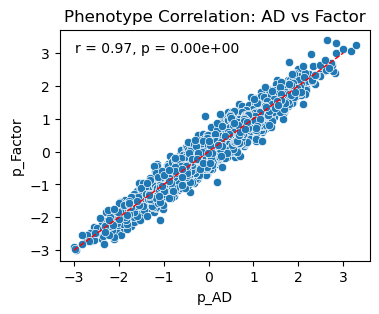

In [142]:
from scipy.stats import pearsonr

dataset_unrel = get_unrel(dataset)

# Calculate correlation
corr, p_value = pearsonr(dataset_unrel["p_AD"], dataset_unrel["p_Factor"])

# Plot scatterplot
plt.figure(figsize=(4, 3))
sns.scatterplot(
    data=dataset_unrel,
    x="p_AD",  # phenotype from AD model
    y="p_Factor",  # phenotype from Factor model
)

# Add correlation text to the plot
plt.text(
    x=0.05, y=0.95,  # Position (relative to the axes)
    s=f"r = {corr:.2f}, p = {p_value:.2e}",  # Correlation and p-value
    fontsize=10,
    ha="left",
    va="top",
    transform=plt.gca().transAxes  # Use axes-relative coordinates
)

# y=x reference line
plt.plot([ -3, 3], [-3, 3], color='red', linestyle='--', linewidth=1)  
plt.title("Phenotype Correlation: AD vs Factor")
plt.show()

## Heritability Estimation: SNP-based vs. Twin-based

In the previous sections, we standardized the genotype data under two different encoding models (AD and Factor) and then generated phenotypes assuming a purely additive genetic architecture.

Using these simulated datasets, we next calculate heritability estimates based on SNP-based methods (AD and Factor GRMs) and compare them with those from twin-based methods (Falconer’s method). Specifically, we examine whether the twin–SNP heritability gap observed in empirical studies can be replicated when phenotypes are simulated under a purely additive condition but with different genotype-encoding models.

In [174]:
# heritability estimation functions

# Function to perform fast ordinary least squares (OLS) regression without standard errors
def fast_ols_no_se(X, y):
    """
    Perform OLS regression to estimate coefficients (β) using the formula:
    β = (X^T X)^(-1) X^T y
    
    Parameters:
        X (np.ndarray): Predictor matrix
        y (np.ndarray): Response vector
    
    Returns:
        np.ndarray: Estimated coefficients (β)
    """
    XtX = X.T @ X  # Compute X^T X
    Xty = X.T @ y  # Compute X^T y
    
    try:
        # Use Cholesky decomposition for faster and more stable matrix inversion
        L = linalg.cholesky(XtX, lower=True)
        z = linalg.solve_triangular(L, Xty, lower=True)
        beta = linalg.solve_triangular(L.T, z, lower=False)
    except:
        # Fallback to least squares solution if Cholesky fails
        beta = linalg.lstsq(X, y)[0]
    
    return beta

# Function to estimate heritability using Falconer's method
def h2_falconer(df):
    """
    Estimate heritability (h2) using Falconer's method based on twin correlations.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing twin data with columns:
            - 'family_id': Family identifier
            - 'twin_type': Type of twin ('MZ' or 'DZ')
            - 'p': Phenotype values
    
    Returns:
        pd.DataFrame: DataFrame with Falconer's heritability estimates
    """
    def reshape_twin_phenotypes(df):
        """
        Reshape twin phenotype data to have one row per family and separate columns for each twin.
        
        Parameters:
            df (pd.DataFrame): DataFrame with 'family_id' and 'p' columns
        
        Returns:
            pd.DataFrame: Reshaped DataFrame with columns 'family_id', 'twin1', and 'twin2'
        """
        return (
            df
            .assign(twin_num=lambda x: x.groupby('family_id').cumcount() + 1)  # Assign twin number within each family
            .pivot(index="family_id", columns="twin_num", values="p")  # Reshape to wide format
            .reset_index()
            .rename(columns={1: 'twin1', 2: 'twin2'})  # Rename columns for clarity
        )
    
    # Separate data for monozygotic (MZ) and dizygotic (DZ) twins
    df_mz = reshape_twin_phenotypes(df[df["twin_type"] == "MZ"][["family_id", "p"]])
    df_dz = reshape_twin_phenotypes(df[df["twin_type"] == "DZ"][["family_id", "p"]])
    
    # Compute correlations between twin pairs for MZ and DZ twins
    corr_mz = np.corrcoef(df_mz["twin1"], df_mz["twin2"])[0, 1]
    corr_dz = np.corrcoef(df_dz["twin1"], df_dz["twin2"])[0, 1]
    
    # Falconer's heritability estimate: h2 = 2 * (r_MZ - r_DZ)
    h2_falconer = 2 * (corr_mz - corr_dz)
    
    return pd.DataFrame({
        "r2_mz": [corr_mz],  # Correlation for MZ twins
        "r2_dz": [corr_dz],  # Correlation for DZ twins
        "h2_twin": [h2_falconer]  # Falconer's heritability estimate
    })

# Function to estimate heritability using the Additive-Dominance (AD) model
def h2_ad(df):
    """
    Estimate heritability using the AD model with additive and dominance genetic relatedness matrices (GRMs).
    
    Parameters:
        df (pd.DataFrame): DataFrame containing genotype and phenotype data
    
    Returns:
        pd.DataFrame: DataFrame with heritability estimates for additive, dominance, and total effects
    """
    y = df["p"].to_numpy().reshape(-1, 1)  # Extract phenotype values
    g = get_genotype_from_df(df)  # Extract genotype matrix
    n_sample, n_snp = g.shape
    afreqs = g.sum(axis=0) / (2 * n_indiv)  # Compute allele frequencies
    
    # Standardize genotype data for additive and dominance components
    g_add, g_dom = std_AD(g, afreqs)
    
    # Compute genetic relatedness matrices (GRMs)
    grm_add = (g_add @ g_add.T) / g_add.shape[1]
    grm_dom = (g_dom @ g_dom.T) / g_dom.shape[1]
    
    # Extract off-diagonal elements of GRMs and phenotype matrix
    offdiag_idx = np.triu_indices(n_sample, k=1)
    grm_offdiag = np.column_stack([grm_add[offdiag_idx], grm_dom[offdiag_idx]])
    prm_offdiag = (y @ y.T)[offdiag_idx]
    
    # Estimate heritability components using OLS
    beta = fast_ols_no_se(grm_offdiag, prm_offdiag)
    return pd.DataFrame({
        "h2_add": [beta[0]],  # Additive heritability
        "h2_dom": [beta[1]],  # Dominance heritability
        "h2_AD": [beta[0] + beta[1]]  # Total heritability (additive + dominance)
    })

# Function to estimate heritability using the Factor model
def h2_factor(df):
    """
    Estimate heritability using the Factor model with heterozygous and homozygous GRMs.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing genotype and phenotype data
    
    Returns:
        pd.DataFrame: DataFrame with heritability estimates for heterozygous, homozygous, and total effects
    """
    y = df["p"].to_numpy().reshape(-1, 1)  # Extract phenotype values
    g = get_genotype_from_df(df)  # Extract genotype matrix
    n_sample, n_snp = g.shape
    afreqs = g.sum(axis=0) / (2 * n_indiv)  # Compute allele frequencies
    
    # Standardize genotype data for heterozygous and homozygous components
    g_het, g_hom = std_Factor(g, afreqs)
    
    # Compute genetic relatedness matrices (GRMs)
    grm_het = (g_het @ g_het.T) / g_het.shape[1]
    grm_hom = (g_hom @ g_hom.T) / g_hom.shape[1]
    grm_hetxhom = ((g_het @ g_hom.T) + (g_hom @ g_het.T)) / g_hom.shape[1]
    
    # Extract off-diagonal elements of GRMs and phenotype matrix
    offdiag_idx = np.triu_indices(n_sample, k=1)
    grm_offdiag = np.column_stack([grm_het[offdiag_idx], grm_hom[offdiag_idx], grm_hetxhom[offdiag_idx]])
    prm_offdiag = (y @ y.T)[offdiag_idx]
    
    # Estimate heritability components using OLS
    beta = fast_ols_no_se(grm_offdiag, prm_offdiag)
    return pd.DataFrame({
        "h2_het": [beta[0]],  # Heterozygous heritability
        "h2_hom": [beta[1]],  # Homozygous heritability
        "cov_hh": [beta[2]],  # Covariance between heterozygous and homozygous effects
        "h2_Factor": [beta[0] + beta[1]]  # Total heritability (heterozygous + homozygous)
    })

We estimated heritability using three different approaches:

1. **Twin-based Heritability ($h^2_{\text{twin}}$)**

Twin-based heritability was calculated using the `h2_falconer()` function, which implements Falconer’s method based on the correlation of phenotypes between monozygotic (MZ) and dizygotic (DZ) twins:

$$
h^2_{\text{twin}} = 2 \times (r_{\text{MZ}} - r_{\text{DZ}})
$$

where $r_{\text{MZ}}$ and $r_{\text{DZ}}$ denote the correlations between MZ and DZ twin pairs, respectively. Although Falconer’s method yields broad-sense heritability ($H^2$), it equals narrow-sense heritability under the purely additive assumption with AD model because we assume no dominance or interaction effects in phenotype generation.


2. SNP-based Heritability

SNP-based heritability was computed using genetic relatedness matrices (GRMs) constructed from unrelated individuals. The off-diagonal elements of the GRMs were used as predictors, while the off-diagonal elements of the phenotype covariance matrix served as the response variable. Heritability components were estimated via ordinary least squares (OLS) regression, implemented in the `fast_ols_no_se()` function for efficient computation.

We considered two SNP-based models:


2.1. **Additive–Dominance (AD) Model**

Under the AD model, heritability was estimated using the `h2_ad()` function, which employs additive ($G_{\text{add}}$) and dominance ($G_{\text{dom}}$) GRMs:

$$
y_i y_j = h^2_{\text{add}} \cdot G_{\text{add}, ij} + h^2_{\text{dom}} \cdot G_{\text{dom}, ij}
$$

where

- $h^2_{\text{add}}$: additive genetic heritability
- $h^2_{\text{dom}}$: dominance genetic heritability
- $y_i, y_j$: phenotypes of individuals $i$ and $j$
- $G_{\text{add}, ij}, G_{\text{dom}, ij}$: additive and dominance genetic relatedness

The total SNP-based heritability for the AD model is defined as $h^2_{\text{AD}} = h^2_{\text{add}} + h^2_{\text{dom}}$.


2.2. **Factor Model**

Under the Factor model, heritability was estimated using the `h2_factor()` function, which incorporates heterozygous ($G_{\text{het}}$), homozygous ($G_{\text{hom}}$), and hetero–homo interaction ($G_{\text{het,hom}}$) GRMs:

$$
y_i y_j = h^2_{\text{het}} \cdot G_{\text{het}, ij} + h^2_{\text{hom}} \cdot G_{\text{hom}, ij} + cov_{\text{het,hom}} \cdot G_{\text{het,hom}, ij}

$$

where
- $h^2_{\text{het}}$: heterozygous genetic heritability
- $h^2_{\text{hom}}$: homozygous genetic heritability
- $cov_{\text{het,hom}}$: hetero–homo covariance component
- $y_i, y_j$: phenotypes of individuals $i$ and $j$
- $G_{\text{het}, ij}, G_{\text{hom}, ij}, G_{\text{het,hom}, ij}$: corresponding GRMs

The total SNP-based heritability for the Factor model is defined as $h^2_{\text{Factor}} = h^2_{\text{het}} + h^2_{\text{hom}}$.


In [158]:
def estimate_three_heritabilityh(df, base_model):
    # true phenotype model = AD
    if base_model == "AD":
        df_p_from_ad = df.rename(columns={"p_AD_std": "p"})
        
        # three heritability estimates
        df_falconer = h2_falconer(df_p_from_ad)
        df_ad = h2_ad(get_unrel(df_p_from_ad))
        df_factor = h2_factor(get_unrel(df_p_from_ad))
        
    # true phenotype model = Factor
    elif base_model == "Factor":
        df_p_from_factor = df.rename(columns={"p_Factor_std": "p"})
        
        # three heritability estimates
        df_falconer = h2_falconer(df_p_from_factor)
        df_ad = h2_ad(get_unrel(df_p_from_factor))
        df_factor = h2_factor(get_unrel(df_p_from_factor))
    
    return pd.concat([df_falconer, df_ad, df_factor], axis=1)
    

Let's estimate heritability with variance by genetic = 0.5 with total phenotypic variance is 1.

In [150]:
res = []
n_indiv, n_snp = 2_000, 100
maf_lim = [0.01, 0.5]
var_g, var_c, var_e = 0.5, 0.1, 0.4

for _ in tqdm(range(1000)):
        
    tmp_simul = pheno_from_purely_additive_condition(
        n_indiv=n_indiv, n_snp=n_snp, maf_lim=maf_lim, 
        var_g=var_g, var_c=var_c, var_e=var_e
    )
    
    tt = estimate_three_heritabilityh(tmp_simul, base_model="AD")
    tt["true_pheno_model"] = "AD"
    res.append(tt)
    tt = estimate_three_heritabilityh(tmp_simul, base_model="Factor")
    tt["true_pheno_model"] = "Factor"
    res.append(tt)

df_res = pd.concat(res).reset_index(drop=True)


100%|██████████| 1000/1000 [08:42<00:00,  1.92it/s]


In [162]:
df_res.head()

,r2_mz,r2_dz,h2_twin,h2_add,h2_dom,h2_AD,h2_het,h2_hom,cov_hh,h2_Factor,true_pheno_model
0,0.608811,0.359445,0.498730,0.517309,-0.000977,0.516332,0.249737,0.258877,0.195395,0.508614,AD
1,0.618082,0.320871,0.594422,0.427438,0.145786,0.573225,0.113495,0.454124,0.237342,0.567619,Factor
2,0.603333,0.337260,0.532147,0.486811,-0.005727,0.481085,0.206596,0.274745,0.189311,0.481341,AD
3,0.614669,0.326145,0.577048,0.410834,0.086768,0.497602,0.112146,0.385986,0.211075,0.498132,Factor
4,0.618856,0.304864,0.627985,0.555468,0.003028,0.558496,0.231188,0.346457,0.150374,0.577645,AD


Because we assumed purely additive condition, let's check three heritability estimate: $h^2_{\text{twin}}$, $h^2_{\text{add}}$ and $h^2_{\text{Factor}}$ in two different phenotype dataset.

In [164]:
(
    df_res
    .groupby("true_pheno_model")
    .mean()
    .round(2)
    [["h2_twin", "h2_add", "h2_Factor"]]
)

,h2_twin,h2_add,h2_Factor
true_pheno_model,,,
AD,0.49,0.50,0.5
Factor,0.54,0.42,0.5


The simulation results shows that under the purely additive condition,

1. when phenotype is generated under the AD model, three estimates yield similar heritability estimates ($h^2_{\text{twin}} \approx h^2_{\text{Factor}} \approx h^2_{\text{add}}$)

2. when phenotype is generated under the Factor model, $h^2_{\text{twin}} > h^2_{\text{Factor}} > h^2_{\text{add}}$, which is counter-intuitive.

To check why this happens under the Factor model, let's inspect the comonents for each heritability estimates.

1. $h^2_{\text{twin}}$ : $r_{\text{mz}}$ and $r_{\text{dz}}$
1. $h^2_{\text{AD}}$ : $h^2_{\text{add}}$ and $h^2_{\text{dom}}$
1. $h^2_{\text{Factor}}$ : $h^2_{\text{het}}$ and $h^2_{\text{hom}}$

In [166]:
(
    df_res
    .groupby("true_pheno_model")
    .mean()
    .round(3)
    [["h2_twin", "r2_mz", "r2_dz"]]
)

,h2_twin,r2_mz,r2_dz
true_pheno_model,,,
AD,0.493,0.595,0.349
Factor,0.539,0.599,0.330


In [ ]:
(
    df_res
    .groupby("true_pheno_model")
    .mean()
    .round(3)
    [["h2_AD", "h2_add", "h2_dom"]]
)

,h2_AD,h2_add,h2_dom
true_pheno_model,,,
AD,0.496,0.496,0.000
Factor,0.498,0.417,0.081


In [169]:
(
    df_res
    .groupby("true_pheno_model")
    .mean()
    .round(3)
    [["h2_Factor", "h2_het", "h2_hom"]]
)

,h2_Factor,h2_het,h2_hom
true_pheno_model,,,
AD,0.499,0.206,0.293
Factor,0.502,0.100,0.401


**Results Summary**

1.	Twin-based Heritability ($h^2_{\text{twin}}$)
    - When the true phenotype model is AD or Factor, $r_{\text{MZ}}$ remains the same across both encoding models.
    - However, $r_{\text{MZ}}$ is smaller when the true phenotype model is Factor compared to AD.
    - Consequently, $h^2_{\text{twin}}$ is larger under the Factor phenotype model than under the AD model.

2.	SNP-based Heritability: AD model ($h^2_{\text{AD}}$)
    - When the true phenotype model is AD, all genetic variance is captured by $h^2_{\text{add}}$ while $h^2_{\text{dom}}$ is zero. This is expected because we assumed a purely additive genetic architecture.
    - In contrast, when the true phenotype model is Factor, $h^2_{\text{add}}$ becomes smaller, and $h^2_{\text{dom}}$ becomes non-zero—even though the same purely additive assumption is applied. This result appears counterintuitive.

3.	SNP-based Heritability: Factor model ($h^2_{\text{Factor}}$)
    - Under the AD phenotype model, $h^2_{\text{hom}} > h^2_{\text{het}}$.
    - Under the Factor phenotype model, $h^2_{\text{hom}} > h^2_{\text{het}}$ as well, and the ratio $h^2_{\text{hom}} / h^2_{\text{het}} = 4$, reflecting the fully additive genetic architecture.


**Overall Interpretation**
- Under a purely additive genetic architecture, when phenotypes are generated using the AD model, all three methods yield nearly identical heritability estimates. This implies that the commonly observed twin–SNP heritability gap cannot be replicated in this scenario.
- However, when phenotypes are generated under the Factor model and SNP heritability is estimated using only additive GRMs, $h^2_{\text{twin}} > h^2_{\text{add}}$ consistently holds. This discrepancy arises solely from differences in genotype encoding, not from underlying genetic effects, and mirrors the phenomenon frequently reported in empirical studies.


# 2. Fixing MAF of causal variants

When the true phenotype model is Factor, the deflation of $r_{dz}$—and the consequent overestimation of $h^2_{\text{twin}}$—arises because $r_{dz}$ no longer reflects fixed additive and dominance genetic relatedness. A detailed explanation of this MAF-dependent $r_{dz}$ profile is provided in the separate notebook `Twin.r_DZ.ipynb`.

Here, to illustrate how this MAF-dependent profile amplifies the twin–SNP heritability gap, we simulated phenotypes while fixing the MAF of the causal variants.

In [193]:
res = []
n_indiv, n_snp = 3_000, 100
var_g, var_c, var_e = 0.5, 0.1, 0.4

for maf in tqdm(np.arange(0.01, 0.5, 0.09)):
    for _ in range(100):
        
        tmp_simul = pheno_from_purely_additive_condition(
            n_indiv=n_indiv, n_snp=n_snp, maf_lim=[maf, maf], 
            var_g=var_g, var_c=var_c, var_e=var_e
        )
        
        tt = estimate_three_heritabilityh(tmp_simul, base_model="AD")
        tt["true_pheno_model"] = "AD"
        tt["MAF"] = maf
        res.append(tt)
        
        tt = estimate_three_heritabilityh(tmp_simul, base_model="Factor")
        tt["true_pheno_model"] = "Factor"
        tt["MAF"] = maf
        res.append(tt)

df_res = pd.concat(res).reset_index(drop=True)


100%|██████████| 6/6 [09:16<00:00, 92.79s/it]


In [194]:
df_res.head()

,r2_mz,r2_dz,h2_twin,h2_add,h2_dom,h2_AD,h2_het,h2_hom,cov_hh,h2_Factor,true_pheno_model,MAF
0,0.578287,0.365058,0.426457,0.425256,0.019207,0.444463,0.420716,0.018496,0.044541,0.439212,AD,0.01
1,0.587576,0.217152,0.740847,0.165367,0.172703,0.338069,0.109328,0.317156,0.167476,0.426484,Factor,0.01
2,0.625540,0.345793,0.559494,0.516479,0.005030,0.521509,0.508452,0.014782,0.065004,0.523235,AD,0.01
3,0.621680,0.174941,0.893479,0.159933,0.709412,0.869346,0.087278,0.766211,0.170648,0.853489,Factor,0.01
4,0.544685,0.323156,0.443058,0.466891,-0.001110,0.465781,0.458047,0.007669,0.064634,0.465717,AD,0.01


## True phenotype model = AD

In [207]:
for_plot_AD = df_res[df_res["true_pheno_model"] == "AD"].copy()

When the true phenotype generation model is AD, the three heritability estimates ($h^2_{\text{twin}}$, $h^2_{\text{AD}}$, and $h^2_{\text{Factor}}$) yield similar values regardless of MAF.

(0.4, 0.6)

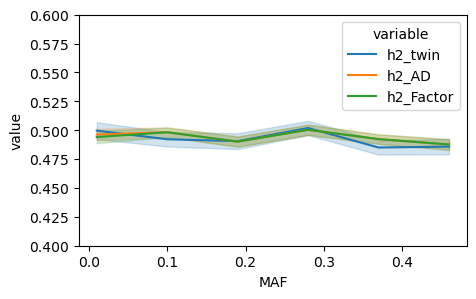

In [ ]:
# three heritability estimates
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=for_plot_AD[["h2_twin", "h2_AD", "h2_Factor", "MAF"]].melt(id_vars="MAF"),
    x="MAF",
    y="value",
    hue="variable",
    errorbar=("se", 1),
)
plt.ylim([0.4, 0.6])


When we inspect the components of the heritability estimates, we observe that $r_{\text{MZ}}$, $r_{\text{DZ}}$, $h^2_{\text{add}}$, and $h^2_{\text{dom}}$ remain constant across MAF values. In contrast, $h^2_{\text{het}}$ and $h^2_{\text{hom}}$ vary with MAF.

<Axes: xlabel='MAF', ylabel='value'>

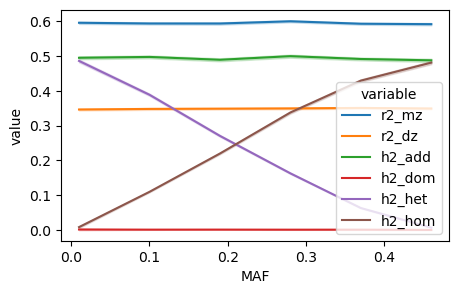

In [209]:
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=for_plot_AD[["r2_mz", "r2_dz", "h2_add", "h2_dom", "h2_het", "h2_hom", "MAF"]].melt(id_vars="MAF"),
    x="MAF",
    y="value",
    hue="variable",
    errorbar=("se", 1),
)


## True phenotype model = Factor

In [210]:
for_plot_Factor = df_res[df_res["true_pheno_model"] == "Factor"].copy()

When the true phenotype generation model is Factor, $h^2_{\text{twin}}$ consistently yields larger values than the two SNP-based heritability estimates, while $h^2_{\text{AD}}$ remains similar to $h^2_{\text{Factor}}$ regardless of MAF.

(0.3, 0.7)

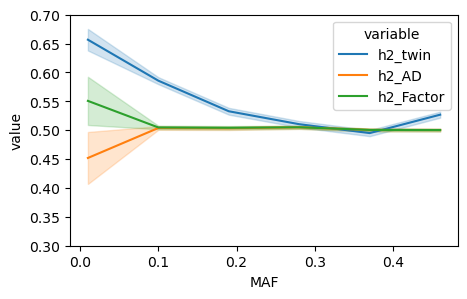

In [213]:
# three heritability estimates
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=for_plot_Factor[["h2_twin", "h2_AD", "h2_Factor", "MAF"]].melt(id_vars="MAF"),
    x="MAF",
    y="value",
    hue="variable",
    errorbar=("se", 1),
)
plt.ylim([0.3, 0.7])


When we inspect the components of the heritability estimates, we observe that $h^2_{\text{het}}$ and $h^2_{\text{hom}}$ remain constant across MAF values. In contrast, $r_{\text{MZ}}$, $r_{\text{DZ}}$, $h^2_{\text{add}}$, and $h^2_{\text{dom}}$ vary with MAF.

<Axes: xlabel='MAF', ylabel='value'>

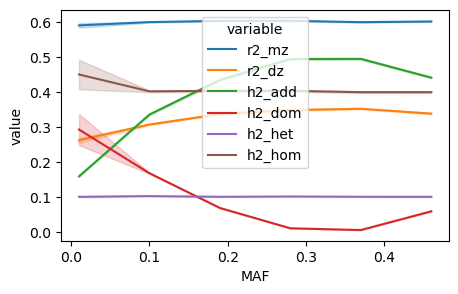

In [215]:
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=for_plot_Factor[["r2_mz", "r2_dz", "h2_add", "h2_dom", "h2_het", "h2_hom", "MAF"]].melt(id_vars="MAF"),
    x="MAF",
    y="value",
    hue="variable",
    errorbar=("se", 1),
)
